In [1]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import sqlite3
import timsrust_pyo3
import time

from bokeh.io import output_notebook, show, export_png
import matplotlib.pyplot as plt

output_notebook()

# set global plotting backend for pandas
pd.options.plotting.backend = "ms_matplotlib" # one of: "ms_bokeh" "ms_matplotlib" "ms_plotly"
pd.set_option('display.width',500)

Loading BokehJS ...

In [2]:
# import requests
# import zipfile
# import os

# # Define the URL and file name
# url = 'https://github.com/MannLabs/alphatims/releases/download/0.1.210317/20201207_tims03_Evo03_PS_SA_HeLa_200ng_EvoSep_prot_DDA_21min_8cm_S1-C10_1_22476.d.zip'
# file_name = '20201207_tims03_Evo03_PS_SA_HeLa_200ng_EvoSep_prot_DDA_21min_8cm_S1-C10_1_22476.d.zip'
# extract_dir = './'  # Directory to extract the contents

# # Download the file
# response = requests.get(url)
# with open(file_name, 'wb') as file:
#     file.write(response.content)

# print(f'File {file_name} downloaded successfully!')

# # Unzip the file
# with zipfile.ZipFile(file_name, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print(f'File extracted to {extract_dir}!')

# # Optionally, remove the zip file after extraction
# os.remove(file_name)
# print(f'Zip file {file_name} removed.')

In [3]:
@dataclass
class DenseFrame:
    rt: float
    intensities: list[int]
    mzs: list[float]
    imss: list[float]

    @classmethod
    def from_frame(
        cls, frame: timsrust_pyo3.PyFrame, reader: timsrust_pyo3.TimsReader
    ):
        mzs = reader.resolve_mzs(frame.tof_indices)
        out_imss = [None] * len(mzs)
        last_so = 0
        for ims, so in zip(
            reader.resolve_scans(list(range(1, len(frame.scan_offsets) + 1))),
            frame.scan_offsets,
            strict=True,
        ):
            out_imss[last_so:so] = [ims] * (so - last_so)
            last_so = so

        return cls(
            rt=frame.rt,
            intensities=frame.intensities,
            mzs=mzs,
            imss=out_imss,
        )

In [4]:
file =  "./20201207_tims03_Evo03_PS_SA_HeLa_200ng_EvoSep_prot_DDA_21min_8cm_S1-C10_1_22476.d/"
start_time = time.time()
reader = timsrust_pyo3.TimsReader(file)
allframes = reader.read_all_frames()
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Time taken to run the code: {elapsed_time:.2f} seconds')

Time taken to run the code: 2.25 seconds


In [5]:
len(allframes)

11886

In [6]:
allframes[0]

PyFrame(index=1, rt=0.564402, frame_type=0, len(scan_offsets)=928, len(tof_indices)=17041, len(intensities)=17041)

In [7]:
df = DenseFrame.from_frame(allframes[0], reader)

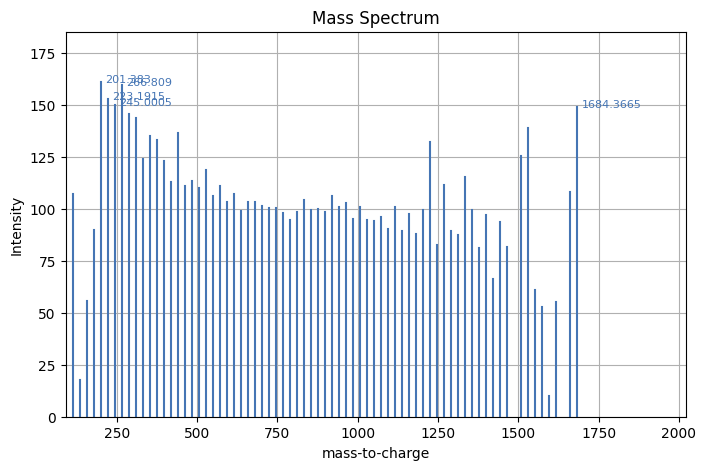

In [8]:
frame_data = pd.DataFrame({'mz':df.mzs, 'im':df.imss, 'int':df.intensities})
frame_data.plot(x='mz', y='int', kind='spectrum', width=800)

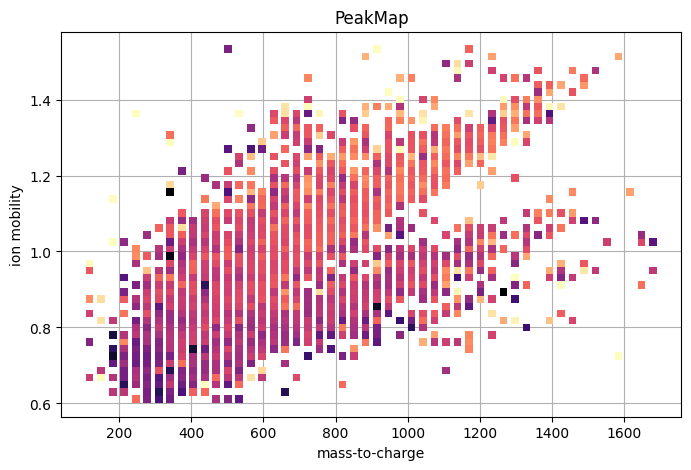

In [9]:
frame_data.plot(x='mz', y='im', z='int', xlabel='mass-to-charge', ylabel='ion mobility', kind='peakmap', width=800)